# Time Series Modelling

- time series in data frames
- properties of time series - what kind can we hope to model?
- stationarity 
- AR, MA and ARIMA models

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [6]:
#
# read air passengers data as a time series 
# as per https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
#

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
#passengers = pd.read_csv('files/AirPassengers.csv')
passengers = pd.read_csv('files/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
# convert to a Series, (one dimensional) rather than a dataframe
# adfuller test and maybe others doesn't work with dataframe
passengers = passengers["#Passengers"]
          
print(passengers.shape)
passengers.head()

(144,)


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [7]:
# a second dataset - sunspot numbers each year
sunspots = pd.read_csv('files/sunspots.csv', parse_dates=["YEAR"],  index_col="YEAR")
sunspots = sunspots['SUNACTIVITY']
sunspots.head()

YEAR
1700-01-01     5.0
1701-01-01    11.0
1702-01-01    16.0
1703-01-01    23.0
1704-01-01    36.0
Name: SUNACTIVITY, dtype: float64

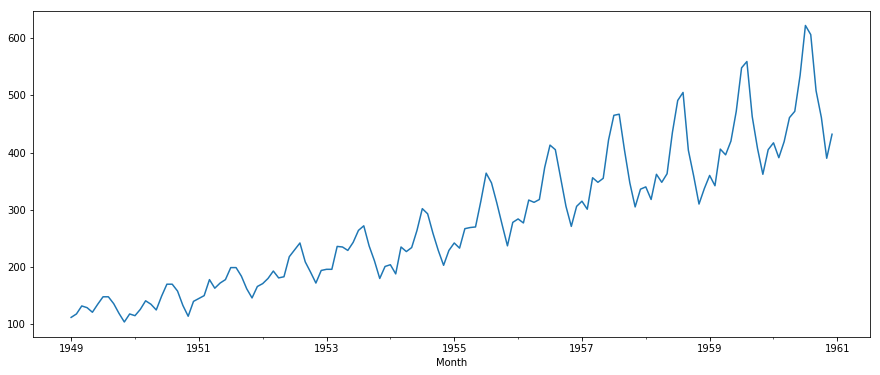

In [8]:
_p = passengers.plot()

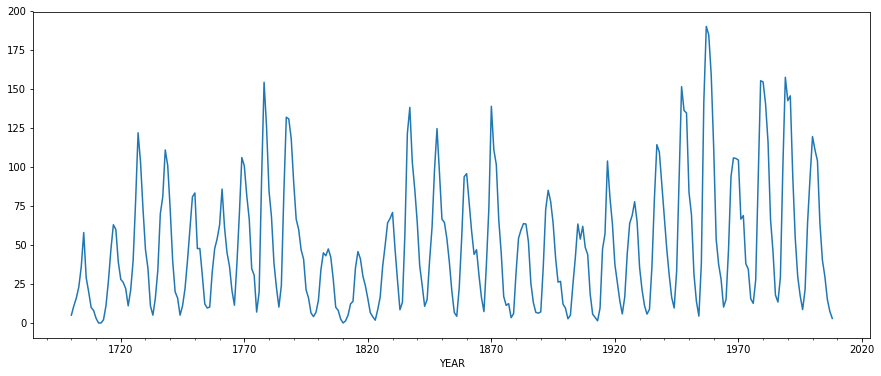

In [9]:
_p = sunspots.plot()

## Stationarity

We can model a time series if it is **stationary** that is, it's statistical properties don't change over time.  If they do, then we can't model the future based on the past - since we know it is going to change. 

We can see in the passengers example that it is not stationary - there is an increasing trend in passenger numbers over time and the size of the yearly oscillations also increases.   For the sunspots, it looks to be closer to being stationary but there is still an oscillation superimposed on the 11 year cycle.
 

## Test for Stationarity

- Visually 
    - look at the rolling mean of the data, it should be relatively flat
    - look at the rolling standard deviation, that should also be flat
- Statistically
    - the **Dickey-Fuller** test is a statistical test
    - the **null hypothesis** is that the time series is **not stationary**
    - use the **p-value** to accept or reject this hypothesis

Look back to the week 4 lecture or section 4.4 in the text book for a discussion of hypothesis testing and p-values.

Here are procedures that are found in a number of discussions of this topic to calculate and plot the rolling means and standard deviations and run the Dickey-Fuller test using the [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) procedure from the `statsmodels` library.  

The first procedure implements a time-series plot overlaid with a smoothed (rolling mean) version of the time series.  The second shows the results of the adfuller test in a readable fashion.

In [10]:
def plot_stationarity(timeseries, window=12):
    """Generate rolling plots of the time series"""
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window,center=False).mean() 
    rolstd = timeseries.rolling(window=window,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


In [11]:
def test_stationarity(timeseries, window=12):
    """Run the Dickey-Fuller test for stationarity"""
  
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

Let's see that work on our example time series.

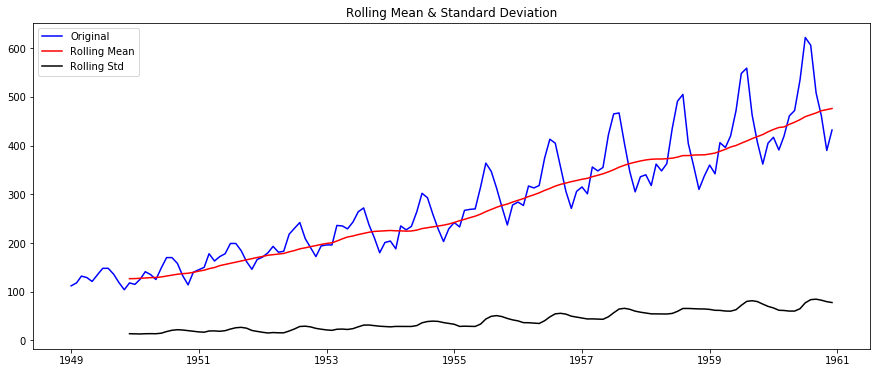

In [12]:
plot_stationarity(passengers)

In [13]:
test_stationarity(passengers)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

The passenger data is not stationary - p-value is 0.99 so the null hypothesis is confirmed.  We can also see the increasing trend in both the mean and stdev of the data.  

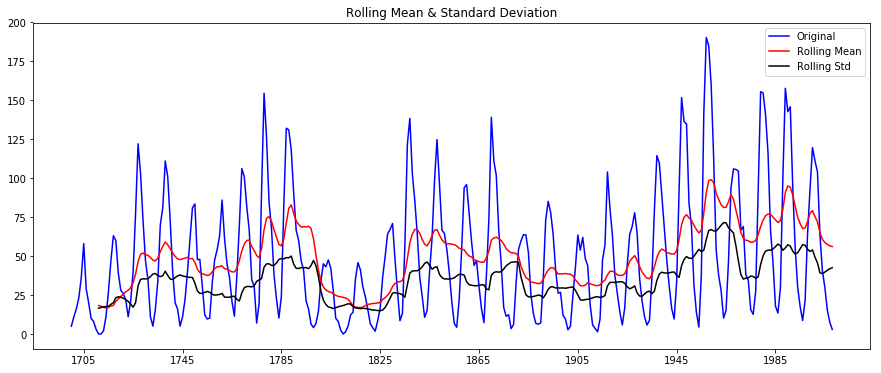

In [14]:
plot_stationarity(sunspots)

In [15]:
test_stationarity(sunspots)

Test Statistic                  -2.837781
p-value                          0.053076
#Lags Used                       8.000000
Number of Observations Used    300.000000
Critical Value (1%)             -3.452337
Critical Value (5%)             -2.871223
Critical Value (10%)            -2.571929
dtype: float64

This is closer to being stationary but still not quite - p-value of 0.053 is just outside the 0.05 threshold we would like.  The mean and stdev can be seen to oscillate over the duration of the time series.  However, this may be close enough to being stationary to allow some kind of modelling. 

## Make it Stationary

It is possible to transform a time series to make it more stationary.  If we can do this using a repeatable transform, we might still be able to get useful predictions from a model (ie. we can apply the inverse transform to the predictions to get the true result).

To make a time series stationary we need to remove some of the things that prevent it being so.  These are:

- the change in the mean over time
- the change in variance over time. 

Here are some techniques for doing this.

- Differencing - subtract the time series from a shifted version of itself, look at change rather than absolute values
- Removing rolling average - model the average separately and remove it from the time series
- Use logarithm to reduce the effect of higher values

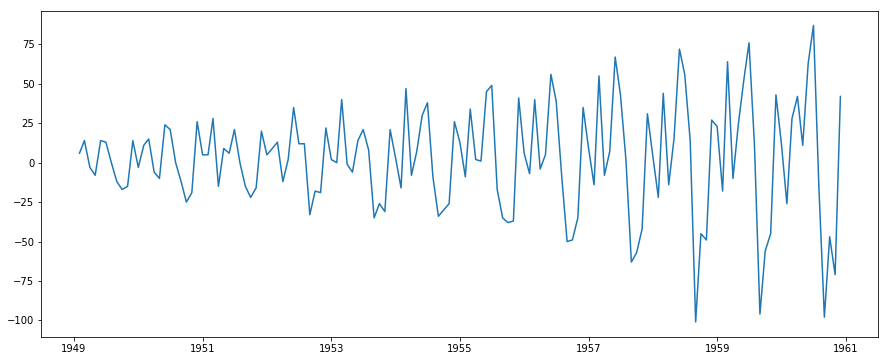

In [16]:
## Differencing - subtract a shifted version of the series from itself

passengers_diff = passengers - passengers.shift()
# need to drop NA values - the first value will be nan because the shifted array is shorter
passengers_diff.dropna(inplace=True)

_p = plt.plot(passengers_diff)

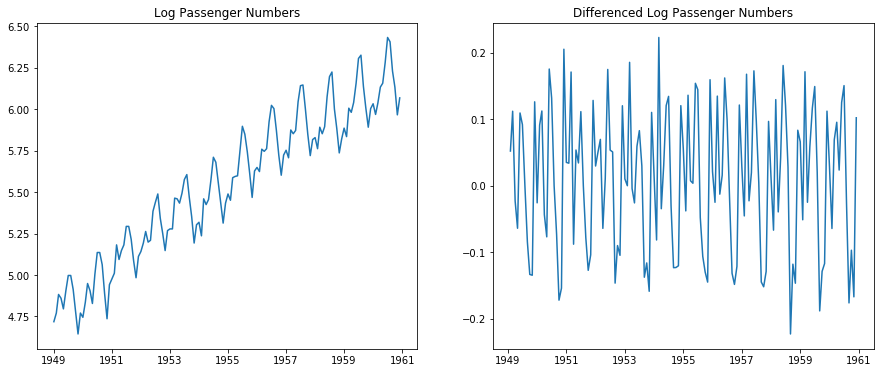

In [17]:
# Logarithm, and then the difference of the logarithm
passengers_log = np.log(passengers)
plt.subplot(121)
plt.plot(passengers_log); plt.title("Log Passenger Numbers")

plt.subplot(122)
passengers_log_diff = passengers_log - passengers_log.shift()
plt.plot(passengers_log_diff); _p = plt.title("Differenced Log Passenger Numbers")

As you can see, taking the logarithm of the time series removes the gradual increas in amplitude of the oscillation later in the series.   Taking the difference of the logarithm gives a time series that is much closer to stationary - it has a mean around zero and a reasonably constant variance. [note that running test_stationarity on this fails because the model fails to converge on this data - I've not had a chance to debug this yet]

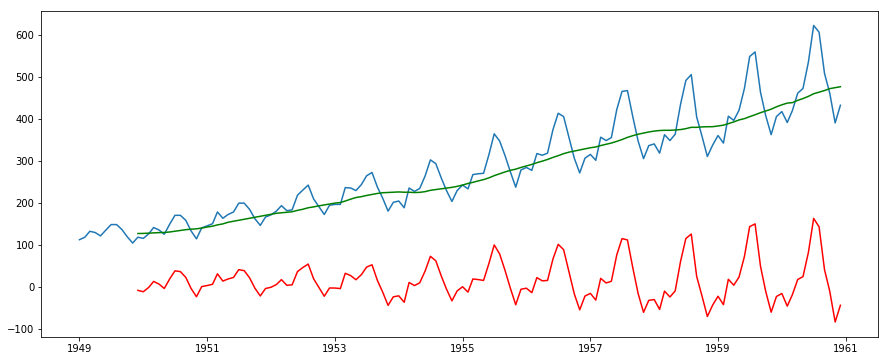

In [18]:
# calculate the rolling mean and substract from the original time series
passengers_avg = passengers.rolling(12).mean()
passengers_m_avg = passengers - passengers_avg

plt.plot(passengers)
plt.plot(passengers_avg, color='green')
_p = plt.plot(passengers_m_avg, color='red')

## Decomposition

Decomposition tries to remove **trend** and **seasonality** from a time series using moving averages and filtering.  

**Trend** is a smooth change over time, modelled by the moving average.

**Seasonality** is a cycle of a fixed period in the data, eg. annual rise and fall of airline passengers

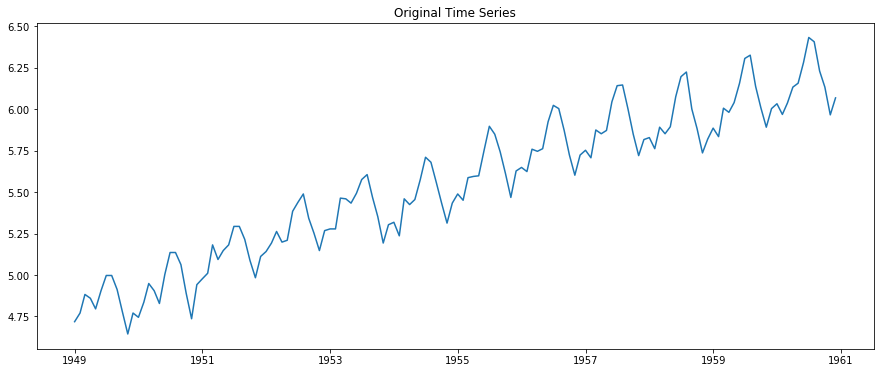

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(passengers_log)
plt.plot(passengers_log)
_p = plt.title("Original Time Series")

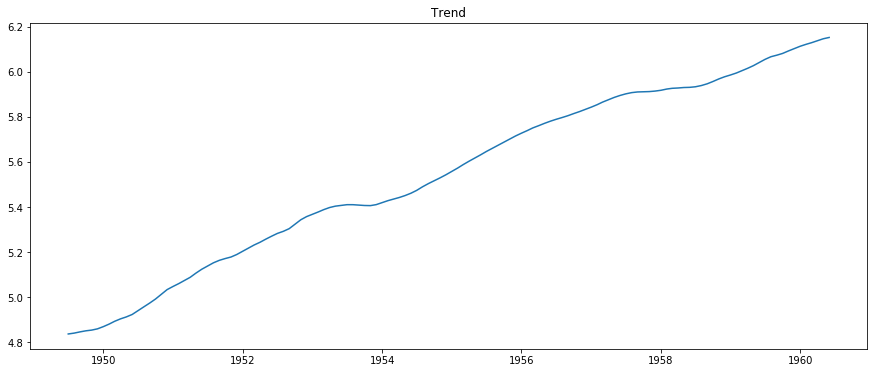

In [20]:
## The trend is the long term variation over time
plt.plot(decomposition.trend, label='Trend')
_p = plt.title("Trend")

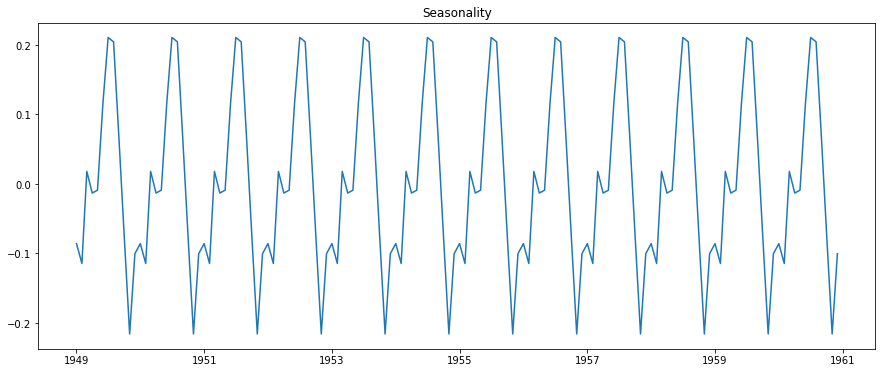

In [21]:
## Seasonality is the periodic change in the variable
plt.plot(decomposition.seasonal)
_p = plt.title("Seasonality")

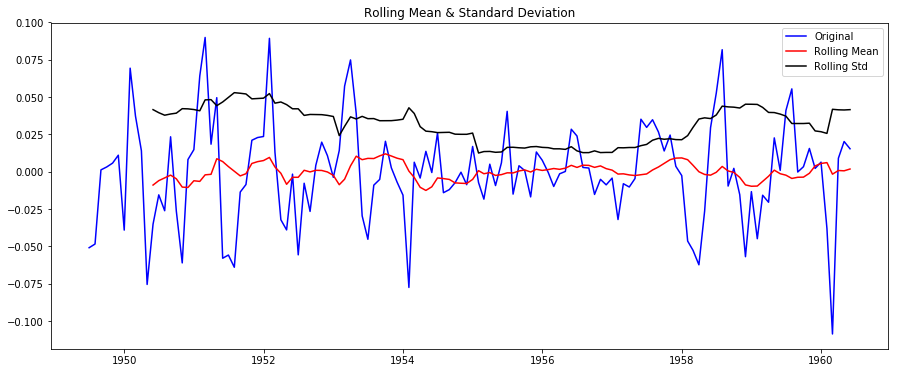

In [22]:
## Residuals are what is left over - this is what we hope is stationary
## need to remove NAs from this to do the stats
residuals = decomposition.resid.dropna()
_p = plot_stationarity(residuals)

In [23]:
test_stationarity(residuals)

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

The p-value in this test is very small, certainly less than 0.05 so we reject the null hypothesis and conclude that we have a stationary signal. 

## Modelling the Time Series

### Autoregresive Models

- Predict the next value in the series based on the past values in the series
- This is a regression model for the variable *against itself* - autoregression

An autoregression model of order $p$ is:

$$y_t = c + b_1 y_{t-1} + b_2 y_{t-2} + b_3 y_{t-3} + ... + b_p y_{t-p} + e_t$$

The coefficients $b_n$ are weights on the *lagged values* of the variable.  $e_t$ is a noise factor.  Call this an $AR(p)$ model.

### Moving Average Models

- predict the next value based on a linear combination of the error terms from previous autoregression predictions

A moving average model of order $q$ is:

$$y_t = c + e_t + d_1 e_{t-1} + d_2 e_{t-2} + ... + d_q e_{t-q}$$

The coefficients $d_n$ here are weights on the previous error measures from an AR model.  

## ARIMA Models

ARIMA (Autoregressive Integrated Moving Average) is a combination of differencing, AR and MA models where we predict the next value based on a combination of both the previous values and the error measures. 

The value $y_t$ is predicted from a weighted sum of:
- values of the *differenced* past time series
- values of the error terms from past AR model predictions


An ARIMA model has three parameters:

- $p$ is the order of the AR part of the model 
- $d$ is the degree of first differencing involved
- $q$ is the order of the MA part of the model

Choosing values for these is difficult but there are some guidelines. 

We can look at the following plots that are based on **autocorrelation** - the correlation between a time series and a shifted version of itself.   These can be used to check for periodicity since a periodic time series will correlate with itself very well if the shift matches the period. 

We use two plots, **acf** and **pacf**. PACF is a Partial autocorrelation function which accounts for the correlation with earlier lags (not too important to understand this). 

In [24]:
def plotacf(data):
    plt.plot(data)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-7.96/np.sqrt(len(sunspots)),linestyle='--',color='gray')
    plt.axhline(y=7.96/np.sqrt(len(sunspots)),linestyle='--',color='gray')

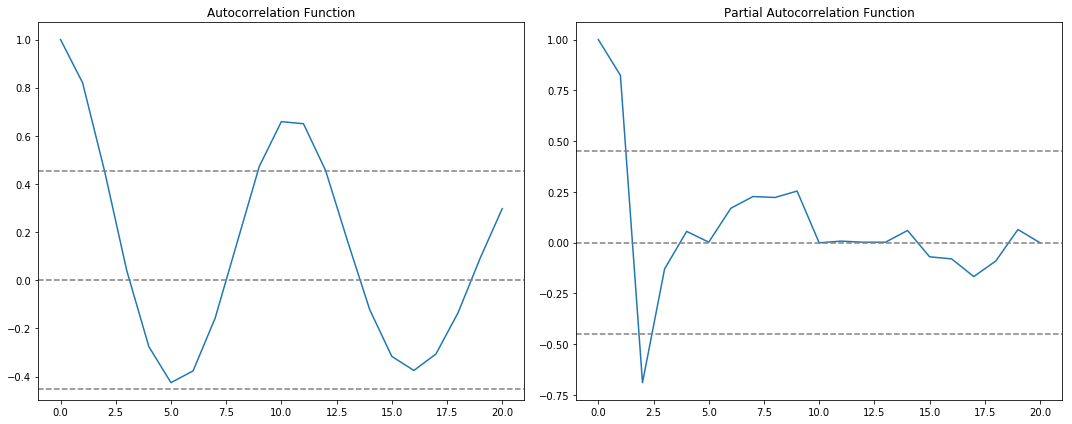

In [25]:
from statsmodels.tsa.stattools import acf, pacf

sunspot_acf = acf(sunspots, nlags=20)
sunspot_pacf = pacf(sunspots, nlags=20, method='ols')
plt.subplot(121); plotacf(sunspot_acf); plt.title('Autocorrelation Function')
plt.subplot(122); plotacf(sunspot_pacf); plt.title('Partial Autocorrelation Function')
plt.tight_layout()

We choose the value for $p$ where the PACF (right) drops to zero for the first time, in this case around 2. 

We choose the value for $q$ where the ACF crosses the upper confidence interval for the first time, in this case it is again 2. 

We can then build an ARIMA model with these figures.  We use a difference $d=0$ so we're not using the differenced version of the signal at all, just the original time series values. 

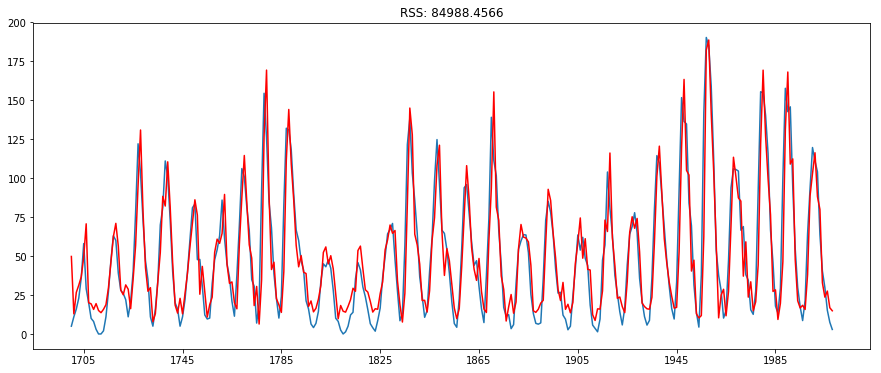

In [26]:
from statsmodels.tsa.arima_model import ARIMA

p = 2; d = 0; q = 2
sunspot_model = ARIMA(sunspots, order=(p, d, q), freq="AS")
sunspot_AR = sunspot_model.fit()
plt.plot(sunspots)
plt.plot(sunspot_AR.fittedvalues, color='red')
_p = plt.title('RSS: %.4f'% sum((sunspot_AR.fittedvalues-sunspots)**2))

Note the `freq="AS"` argument to ARIMA is required to prevent a warning, it relates to the frequency of the underlying time series. `"AS"` refers to 'year start frequency' - [see these docs](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) since our time series contains yearly observations for January 1 each year. 

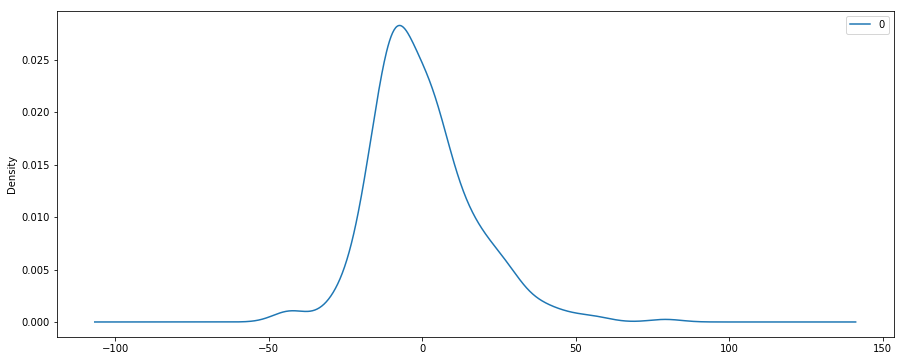

In [27]:
# plot residual errors
residuals = pd.DataFrame(sunspot_AR.resid)
_p = residuals.plot(kind='kde')

The result is a pretty good fit in this case, with the red line following the original sunspot data quite closely apart from in the troughs of the curve.  However the residuals show that the errors are reasonably big (up to 50 each side).

We can use the predict method on the model to make predictions for future observations. Since we're predicting a time series this can just take start and end times and will predict all points in between.

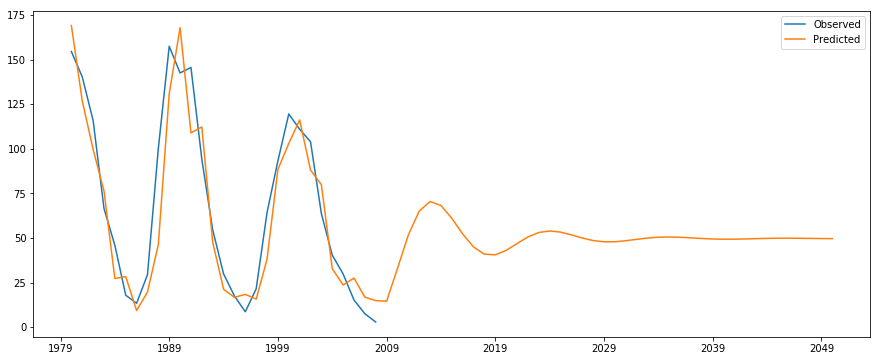

In [28]:
plt.plot(sunspots['1980-01-01':], label="Observed")
plt.plot(sunspot_AR.predict(start="1980-01-01", end="2050-01-01"), label="Predicted")
_p = plt.legend()

## Summary

- Time series data - observations of a variable at a fixed frequency over time
- Stationarity is a pre-requisite for modeling - data is stable over time
- Techniques to create a stationary time series
- Maybe decompose signal to remove trend and seasonal variation
- ARIMA model predicts future values based on past values
- What about if we have multiple observations? 
    - E.g. the price of wheat, temperature, rainfall
    - May just be a regular (eg. linear) model - time is not the major predictor
    - Can introduce __exogenous__ variables into the ARIMA model

## Links

- [ARIMA Models](https://www.otexts.org/fpp/8) chapter from Forecasting principles and practice by Hyndman and Athanasopoulos
- [A comprehensive beginnerâ€™s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) from Analytics Vidhya
- [Forecast Seasonal Time Series](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c) shows how to use a variation on the ARIMA model to predict values for a seasonal time series (using a different python module)